# MNIST images denoising

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from vision_transfoermers import AddGaussianNoise, Clipper

In [2]:
sns.set_style('darkgrid')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading and transforming data

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                AddGaussianNoise(std=0.2),
                                Clipper(high=1.)])

batch_size = 32
dataset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 81919839.62it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5918585.71it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31794716.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1695792.13it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



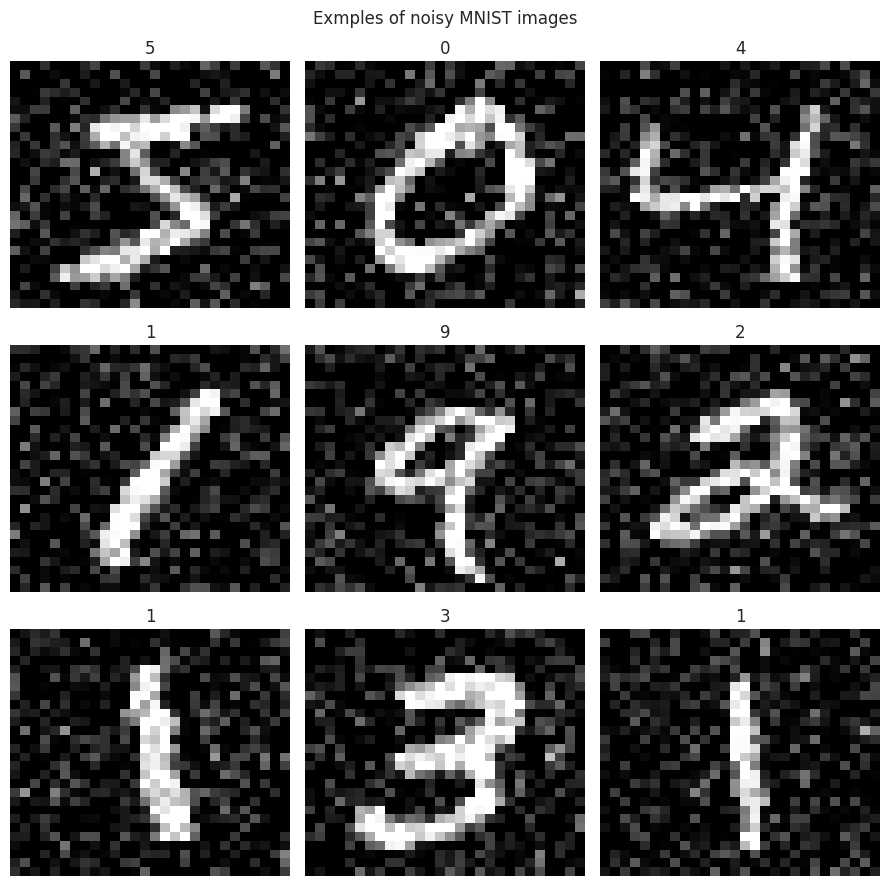

In [42]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))

for idx, axi in enumerate(ax.flat):
  image, label = dataset[idx]
  sns.heatmap(image.reshape(28, 28), ax=axi, cmap="gray", cbar=False)
  axi.set_title(label)
  axi.set_xticks([])
  axi.set_yticks([])
plt.suptitle("Exmples of noisy MNIST images")
plt.tight_layout()
plt.show()

### Autoencoder model

In [7]:
class AutoEncoder(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 584),
        nn.ReLU(),
        nn.BatchNorm1d(584),
        nn.Linear(584, 328),
        nn.ReLU(),
        nn.BatchNorm1d(328),
        nn.Linear(328, 100)
    )

    self.decoder = nn.Sequential(
        nn.Linear(100, 328),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(328, 584),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(584, 28*28)
    )

  def forward(self, x):
    return self.decoder(self.encoder(x))

In [8]:
epochs = 30
lr = 0.0005

autoencoder = AutoEncoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
criterion = nn.MSELoss()

In [9]:
losses = []

for epoch in range(epochs):
  epoch_loss = 0

  for x, _ in loader:
    x = x.view(-1, 784).to(device)
    optimizer.zero_grad()
    decoded = autoencoder(x)
    loss = criterion(decoded, x)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  epoch_loss /= len(loader)
  losses.append(epoch_loss)
  print(f"Epoch: {epoch+1} - Loss: {epoch_loss}")

Epoch: 1 - Loss: 0.034850468250115715
Epoch: 2 - Loss: 0.0287797755608956
Epoch: 3 - Loss: 0.027569753559430442
Epoch: 4 - Loss: 0.026862786124149957
Epoch: 5 - Loss: 0.02638011550605297
Epoch: 6 - Loss: 0.025992461960514388
Epoch: 7 - Loss: 0.02572617692252
Epoch: 8 - Loss: 0.025444571896394094
Epoch: 9 - Loss: 0.02524538860619068
Epoch: 10 - Loss: 0.025063869793216387
Epoch: 11 - Loss: 0.02487467990120252
Epoch: 12 - Loss: 0.02473076254427433
Epoch: 13 - Loss: 0.024606022780140242
Epoch: 14 - Loss: 0.024489018712441128
Epoch: 15 - Loss: 0.024385324399669964
Epoch: 16 - Loss: 0.024282682763536772
Epoch: 17 - Loss: 0.024186439858873685
Epoch: 18 - Loss: 0.02412304813861847
Epoch: 19 - Loss: 0.024044803724686304
Epoch: 20 - Loss: 0.02398220844467481
Epoch: 21 - Loss: 0.023919930818676948
Epoch: 22 - Loss: 0.02387450345357259
Epoch: 23 - Loss: 0.02382545374929905
Epoch: 24 - Loss: 0.02377360890209675
Epoch: 25 - Loss: 0.023756050876776378
Epoch: 26 - Loss: 0.02370619603296121
Epoch: 27 -

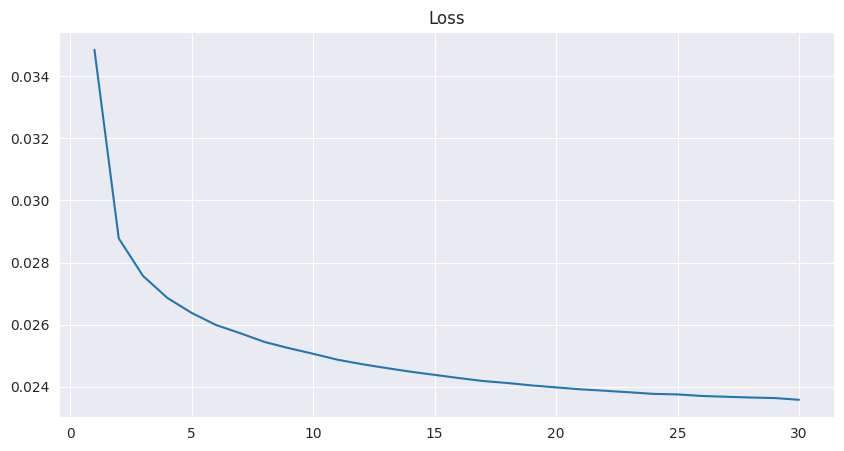

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(x=range(1, epochs+1), y=losses)
plt.title("Loss")
plt.show()

In [13]:
batch_of_images = next(iter(loader))
images, labels = batch_of_images[0][:9], batch_of_images[1][:9]

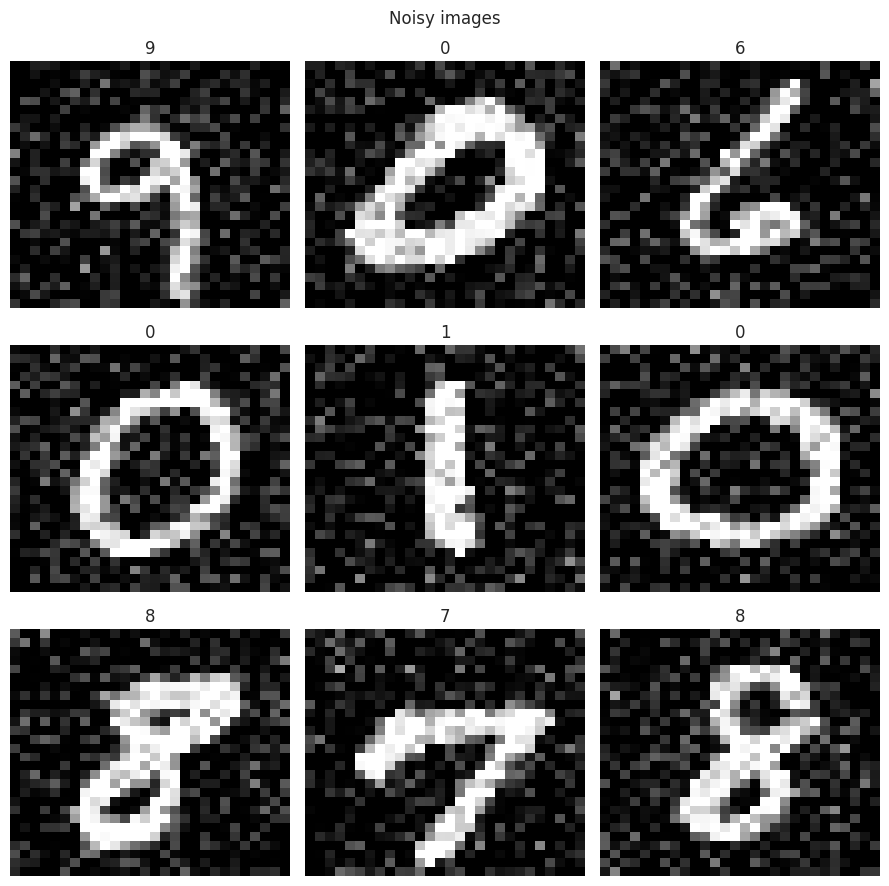

In [40]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))

for idx, axi in enumerate(ax.flat):
  sns.heatmap(images[idx].reshape(28, 28).detach().cpu(), ax=axi, cmap="gray", cbar=False)
  axi.set_title(labels[idx].item())
  axi.set_xticks([])
  axi.set_yticks([])
plt.suptitle("Noisy images")
plt.tight_layout()
plt.show()

In [28]:
with torch.no_grad():
  denoised = autoencoder(images.reshape(9, 28*28).to(device))

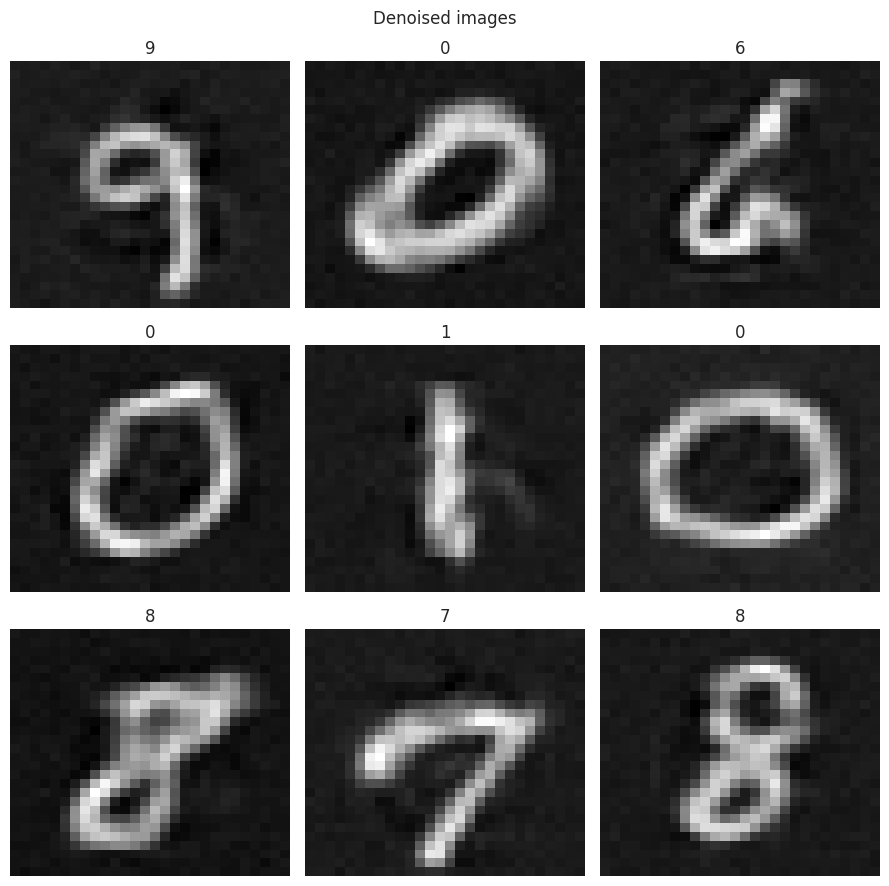

In [41]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))

for idx, axi in enumerate(ax.flat):
  sns.heatmap(denoised[idx].reshape(28, 28).detach().cpu(), ax=axi, cmap="gray", cbar=False)
  axi.set_title(labels[idx].item())
  axi.set_xticks([])
  axi.set_yticks([])
plt.suptitle("Denoised images")
plt.tight_layout()
plt.show()